##### Copyright 2021 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFP リリースノートノートブック (0.13.0)

このノートブックでは、いくつかの小さなスニペット（デモ）を介して TFP 0.11.0 で実現できることを紹介します。

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/probability/examples/TFP_Release_Notebook_0_13_0">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a> </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/TFP_Release_Notebook_0_13_0.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">     Google Colab で実行</a> </td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/TFP_Release_Notebook_0_13_0.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">     GitHubでソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/probability/examples/TFP_Release_Notebook_0_13_0.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

In [1]:
#@title Installs & imports { vertical-output: true }
!pip3 install -qU tensorflow==2.5.0 tensorflow_probability==0.13.0 tensorflow-datasets inference_gym

import tensorflow as tf
import tensorflow_probability as tfp
assert '0.13' in tfp.__version__, tfp.__version__
assert '2.5' in tf.__version__, tf.__version__

physical_devices = tf.config.list_physical_devices('CPU')
tf.config.set_logical_device_configuration(
    physical_devices[0],
    [tf.config.LogicalDeviceConfiguration(),
     tf.config.LogicalDeviceConfiguration()])

tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import IPython
import seaborn as sns
import logging

     |████████████████████████████████| 5.4MB 8.8MB/s 
     |████████████████████████████████| 3.9MB 37.1MB/s 
     |████████████████████████████████| 296kB 31.6MB/s 


## ディストリビューション [コア数学]

### `BetaQuotient`

2 つの独立したベータ分布確率変数の比率

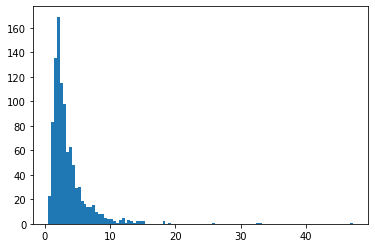

In [2]:
plt.hist(tfd.BetaQuotient(concentration1_numerator=5.,
                          concentration0_numerator=2.,
                          concentration1_denominator=3.,
                          concentration0_denominator=8.).sample(1_000, seed=(1, 23)),
         bins='auto');

### `DeterminantalPointProcess`

特定のセットのサブセット（ワンホットとして表される）にわたるディストリビューション。サンプルは反発特性（確率は、選択したポイントのサブセットに対応するベクトルがまたがるボリュームに比例します）に従います。これは、さまざまなサブセットをサンプリングする傾向があります。[i.i.d ベルヌーイサンプルと比較してください。]

tfp.distributions.DeterminantalPointProcess("DeterminantalPointProcess", batch_shape=[4], event_shape=[256], dtype=int32)


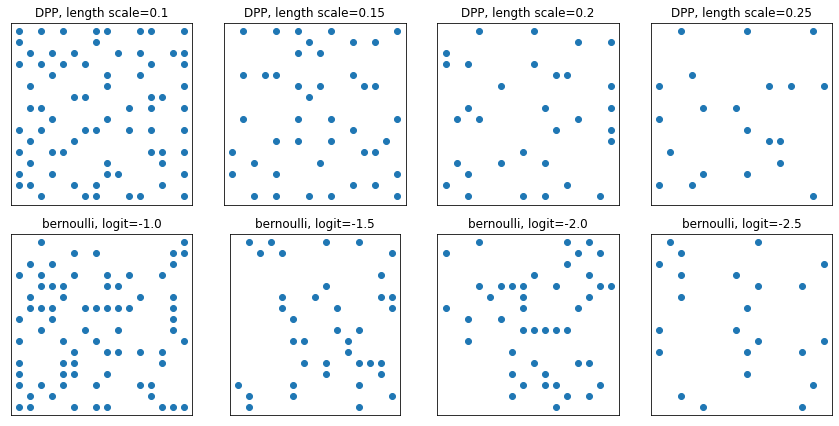

In [3]:
grid_size = 16
# Generate grid_size**2 pts on the unit square.
grid = np.arange(0, 1, 1./grid_size).astype(np.float32)
import itertools
points = np.array(list(itertools.product(grid, grid)))

# Create the kernel L that parameterizes the DPP.
kernel_amplitude = 2.
kernel_lengthscale = [.1, .15, .2, .25]  # Increasing length scale indicates more points are "nearby", tending toward smaller subsets.
kernel = tfpk.ExponentiatedQuadratic(kernel_amplitude, kernel_lengthscale)
kernel_matrix = kernel.matrix(points, points)

eigenvalues, eigenvectors = tf.linalg.eigh(kernel_matrix)
dpp = tfd.DeterminantalPointProcess(eigenvalues, eigenvectors)
print(dpp)

# The inner-most dimension of the result of `dpp.sample` is a multi-hot
# encoding of a subset of {1, ..., ground_set_size}.
# We will compare against a bernoulli distribution.
samps_dpp = dpp.sample(seed=(1, 2))  # 4 x grid_size**2
logits = tf.broadcast_to([[-1.], [-1.5], [-2], [-2.5]], [4, grid_size**2])
samps_bern = tfd.Bernoulli(logits=logits).sample(seed=(2, 3))

plt.figure(figsize=(12, 6))
for i, (samp, samp_bern) in enumerate(zip(samps_dpp, samps_bern)):
  plt.subplot(241 + i)
  plt.scatter(*points[np.where(samp)].T)
  plt.title(f'DPP, length scale={kernel_lengthscale[i]}')
  plt.xticks([])
  plt.yticks([])
  plt.gca().set_aspect(1.)
  plt.subplot(241 + i + 4)
  plt.scatter(*points[np.where(samp_bern)].T)
  plt.title(f'bernoulli, logit={logits[i,0]}')
  plt.xticks([])
  plt.yticks([])
  plt.gca().set_aspect(1.)

plt.tight_layout()
plt.show()

### `SigmoidBeta`

2 つのガンマ分布の対数オッズ。`Beta` よりもサンプル空間が数値的に安定しています。

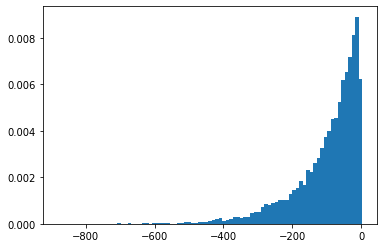

Old way, fractions non-finite:
0.4215
0.8624


In [4]:
plt.hist(tfd.SigmoidBeta(concentration1=.01, concentration0=2.).sample(10_000, seed=(1, 23)),
         bins='auto', density=True);
plt.show()

print('Old way, fractions non-finite:')
print(np.sum(~tf.math.is_finite(
    tfb.Invert(tfb.Sigmoid())(tfd.Beta(concentration1=.01, concentration0=2.)).sample(10_000, seed=(1, 23)))) / 10_000)
print(np.sum(~tf.math.is_finite(
    tfb.Invert(tfb.Sigmoid())(tfd.Beta(concentration1=2., concentration0=.01)).sample(10_000, seed=(2, 34)))) / 10_000)

### Zipf

JAX サポートが追加されました。

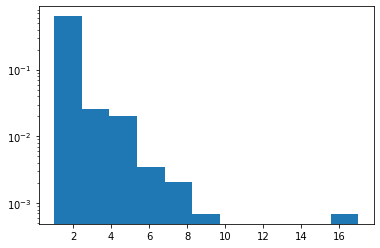

In [5]:
plt.hist(tfd.Zipf(3.).sample(1_000, seed=(12, 34)).numpy(), bins='auto', density=True, log=True);

### `NormalInverseGaussian`

裾が重い、歪んだ、バニラ正規分布をサポートする柔軟なパラメータのファミリ。

### `MatrixNormalLinearOperator`

行列正規分布。

In [6]:
# Initialize a single 2 x 3 Matrix Normal.
mu = [[1., 2, 3], [3., 4, 5]]
col_cov = [[ 0.36,  0.12,  0.06],
           [ 0.12,  0.29, -0.13],
           [ 0.06, -0.13,  0.26]]
scale_column = tf.linalg.LinearOperatorLowerTriangular(tf.linalg.cholesky(col_cov))
scale_row = tf.linalg.LinearOperatorDiag([0.9, 0.8])

mvn = tfd.MatrixNormalLinearOperator(loc=mu, scale_row=scale_row, scale_column=scale_column)
mvn.sample()

Instructions for updating:
Do not call `graph_parents`.


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1.2495145, 1.549366 , 3.2748342],
       [3.7330258, 4.3413105, 4.83423  ]], dtype=float32)>

### `MatrixStudentTLinearOperator`

行列 T 分布。

In [7]:
mu = [[1., 2, 3], [3., 4, 5]]
col_cov = [[ 0.36,  0.12,  0.06],
           [ 0.12,  0.29, -0.13],
           [ 0.06, -0.13,  0.26]]
scale_column = tf.linalg.LinearOperatorLowerTriangular(tf.linalg.cholesky(col_cov))
scale_row = tf.linalg.LinearOperatorDiag([0.9, 0.8])

mvn = tfd.MatrixTLinearOperator(
    df=2.,
    loc=mu,
    scale_row=scale_row,
    scale_column=scale_column)
mvn.sample()

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1.6549466, 2.6708362, 2.8629923],
       [2.1222284, 3.6904747, 5.08014  ]], dtype=float32)>

## ディストリビューション [ソフトウェア/ラッパー]

### `Sharded`

複数のプロセッサにまたがるディストリビューションの独立したイベント部分をシャーディングします。デバイス間で `log_prob` を集約し、`tfp.experimental.distribute.JointDistribution*` と連携して勾配を処理します。詳細は[分散推論](https://www.tensorflow.org/probability/examples/Distributed_Inference_with_JAX)ノートブックを参照してください。

In [8]:
strategy = tf.distribute.MirroredStrategy()

@tf.function
def sample_and_lp(seed):
  d = tfp.experimental.distribute.Sharded(tfd.Normal(0, 1))
  s = d.sample(seed=seed)
  return s, d.log_prob(s)

strategy.run(sample_and_lp, args=(tf.constant([12,34]),))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:1').


(PerReplica:{
   0: <tf.Tensor: shape=(), dtype=float32, numpy=0.0051413667>,
   1: <tf.Tensor: shape=(), dtype=float32, numpy=-0.3393052>
 }, PerReplica:{
   0: <tf.Tensor: shape=(), dtype=float32, numpy=-1.8954543>,
   1: <tf.Tensor: shape=(), dtype=float32, numpy=-1.8954543>
 })

### `BatchBroadcast`

基になる分布のバッチディメンションを特定のバッチ形状に暗黙的にブロードキャストします。

In [9]:
underlying = tfd.MultivariateNormalDiag(tf.zeros([7, 1, 5]), tf.ones([5]))
print('underlying:', underlying)

d = tfd.BatchBroadcast(underlying, [8, 1, 6])
print('broadcast [7, 1] *with* [8, 1, 6]:', d)

try:
  tfd.BatchBroadcast(underlying, to_shape=[8, 1, 6])
except ValueError as e:
  print('broadcast [7, 1] *to* [8, 1, 6] is invalid:', e)

d = tfd.BatchBroadcast(underlying, to_shape=[8, 7, 6])
print('broadcast [7, 1] *to* [8, 7, 6]:', d)

underlying: tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[7, 1], event_shape=[5], dtype=float32)
broadcast [7, 1] *with* [8, 1, 6]: tfp.distributions.BatchBroadcast("BatchBroadcastMultivariateNormalDiag", batch_shape=[8, 7, 6], event_shape=[5], dtype=float32)
broadcast [7, 1] *to* [8, 1, 6] is invalid: Argument `to_shape` ([8 1 6]) is incompatible with underlying distribution batch shape ((7, 1)).
broadcast [7, 1] *to* [8, 7, 6]: tfp.distributions.BatchBroadcast("BatchBroadcastMultivariateNormalDiag", batch_shape=[8, 7, 6], event_shape=[5], dtype=float32)


### `Masked`

単一プログラム/複数データまたはスパースにマスクされた高密度のユースケースの場合、無効な基になるディストリビューションの `log_prob` をマスクするディストリビューション。

In [10]:
d = tfd.Masked(tfd.Normal(tf.zeros([7]), 1), 
               validity_mask=tf.sequence_mask([3, 4], 7))
print(d.log_prob(d.sample(seed=(1, 1))))

d = tfd.Masked(tfd.Normal(0, 1), 
               validity_mask=[False, True, False],
               safe_sample_fn=tfd.Distribution.mode)
print(d.log_prob(d.sample(seed=(2, 2))))

tf.Tensor(
[[-2.3054113 -1.8524303 -1.2220721  0.         0.         0.
   0.       ]
 [-1.118623  -1.1370811 -1.1574132 -5.884986   0.         0.
   0.       ]], shape=(2, 7), dtype=float32)
tf.Tensor([ 0.         -0.93683904  0.        ], shape=(3,), dtype=float32)


## Bijectors

- Bijectors
    - `tf.nest.flatten` (`tfb.tree_flatten`) と`tf.nest.pack_sequence_as` (`tfb.pack_sequence_as`)を模倣するバイジェクタを追加します。
    - `tfp.experimental.bijectors.Sharded` を追加します。
    - 非推奨の `tfb.ScaleTrilL` を削除します。代わりに `tfb.FillScaleTriL` を使用します。
    - Bijectors に `cls.parameter_properties()` アノテーションを追加します。
    - 範囲 `tfb.Power` を、奇数の整数乗のすべての実数に拡張します。
    - 特に指定がない限り、autodiff を使用してスカラー bijector の対数次数ヤコビアンを推測します。


### バイジェクタの再構築

In [11]:
ex = (tf.constant(1.), dict(b=tf.constant(2.), c=tf.constant(3.)))
b = tfb.tree_flatten(ex)
print(b.forward(ex))
print(b.inverse(list(tf.constant([1., 2, 3]))))

b = tfb.pack_sequence_as(ex)
print(b.forward(list(tf.constant([1., 2, 3]))))
print(b.inverse(ex))

[<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=2.0>, <tf.Tensor: shape=(), dtype=float32, numpy=3.0>]
(<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, {'b': <tf.Tensor: shape=(), dtype=float32, numpy=2.0>, 'c': <tf.Tensor: shape=(), dtype=float32, numpy=3.0>})
(<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, {'b': <tf.Tensor: shape=(), dtype=float32, numpy=2.0>, 'c': <tf.Tensor: shape=(), dtype=float32, numpy=3.0>})
[<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=2.0>, <tf.Tensor: shape=(), dtype=float32, numpy=3.0>]


### `Sharded`

対数行列式の SPMD 削減。下記のディストリビューションの `Sharded` を参照してください。

In [13]:
strategy = tf.distribute.MirroredStrategy()

def sample_lp_logdet(seed):
  d = tfd.TransformedDistribution(tfp.experimental.distribute.Sharded(tfd.Normal(0, 1), shard_axis_name='i'),
                                  tfp.experimental.bijectors.Sharded(tfb.Sigmoid(), shard_axis_name='i'))
  s = d.sample(seed=seed)
  return s, d.log_prob(s), d.bijector.inverse_log_det_jacobian(s)
strategy.run(sample_lp_logdet, (tf.constant([1, 2]),))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:1').


(PerReplica:{
   0: <tf.Tensor: shape=(), dtype=float32, numpy=0.87746525>,
   1: <tf.Tensor: shape=(), dtype=float32, numpy=0.24580425>
 }, PerReplica:{
   0: <tf.Tensor: shape=(), dtype=float32, numpy=-0.48870325>,
   1: <tf.Tensor: shape=(), dtype=float32, numpy=-0.48870325>
 }, PerReplica:{
   0: <tf.Tensor: shape=(), dtype=float32, numpy=3.9154015>,
   1: <tf.Tensor: shape=(), dtype=float32, numpy=3.9154015>
 })

## VI

- `build_split_flow_surrogate_posterior` を `tfp.experimental.vi` に追加して、正規化フローから構造化 VI 代理事後確率を構築します。
- `build_affine_surrogate_posterior` を `tfp.experimental.vi` に追加して、イベント形状から ADVI 代理事後確率を構築します。
- `build_affine_surrogate_posterior_from_base_distribution` を `tfp.experimental.vi` に追加して、アフィン変換によって誘導された相関構造を持つ ADVI 代理事後確率の構築を可能にします。


### VI/MAP/MLE

- ディストリビューションとバイジェクターのトレーニング可能なインスタンスを作成するための便利なメソッド `tfp.experimental.util.make_trainable(cls)` を追加しました。

In [ ]:
d = tfp.experimental.util.make_trainable(tfd.Gamma)
print(d.trainable_variables)
print(d)

(<tf.Variable 'Gamma_trainable_variables/concentration:0' shape=() dtype=float32, numpy=1.0296053>, <tf.Variable 'Gamma_trainable_variables/log_rate:0' shape=() dtype=float32, numpy=-0.3465951>)
tfp.distributions.Gamma("Gamma", batch_shape=[], event_shape=[], dtype=float32)


## MCMC

- MCMC 診断は、リストだけでなく、状態の任意の構造をサポートします。
- `remc_thermodynamic_integrals` が`tfp.experimental.mcmc` に追加されました。
- `tfp.experimental.mcmc.windowed_adaptive_hmc` を追加します。
- 制約のない空間でほぼゼロの一様分布からマルコフ連鎖を初期化するための実験的な API を追加します。`tfp.experimental.mcmc.init_near_unconstrained_zero`
- 許容できる点が見つかるまでマルコフ連鎖の初期化を再試行するための実験的なユーティリティを追加します。`tfp.experimental.mcmc.retry_init`
- 実験的なストリーミング MCMC API をシャッフルして、中断を最小限に抑えて tfp.mcmc にスロットインします。
- `ThinningKernel` to `experimental.mcmc` を追加します。
- ストリーミングベースの代替候補として `experimental.mcmc.run_kernel`ドライバを `mcmc.sample_chain` に追加します


### `init_near_unconstrained_zero`、`retry_init`

In [73]:
@tfd.JointDistributionCoroutine
def model():
  Root = tfd.JointDistributionCoroutine.Root
  c0 = yield Root(tfd.Gamma(2, 2, name='c0'))
  c1 = yield Root(tfd.Gamma(2, 2, name='c1'))
  counts = yield tfd.Sample(tfd.BetaBinomial(23, c1, c0), 10, name='counts')
jd = model.experimental_pin(counts=model.sample(seed=[20, 30]).counts)

init_dist = tfp.experimental.mcmc.init_near_unconstrained_zero(jd)
print(init_dist)

tfp.experimental.mcmc.retry_init(init_dist.sample, jd.unnormalized_log_prob)

tfp.distributions.TransformedDistribution("default_joint_bijectorrestructureJointDistributionSequential", batch_shape=StructTuple(
  c0=[],
  c1=[]
), event_shape=StructTuple(
  c0=[],
  c1=[]
), dtype=StructTuple(
  c0=float32,
  c1=float32
))


StructTuple(
  c0=<tf.Tensor: shape=(), dtype=float32, numpy=1.7879653>,
  c1=<tf.Tensor: shape=(), dtype=float32, numpy=0.34548905>
)

### ウィンドウ化されたアダプティブ HMC および NUTS サンプラー

StructTuple(
  c0=<tf.Tensor: shape=(), dtype=float32, numpy=0.7161876>,
  c1=<tf.Tensor: shape=(), dtype=float32, numpy=1.7696666>,
  counts=<tf.Tensor: shape=(10,), dtype=float32, numpy=array([ 6., 10., 23.,  7.,  2., 20., 14., 16., 22., 17.], dtype=float32)>
)
StructTuple(
  c0=<tf.Tensor: shape=(), dtype=float32, numpy=0.7161876>,
  c1=<tf.Tensor: shape=(), dtype=float32, numpy=1.7696666>,
  counts=<tf.Tensor: shape=(250,), dtype=float32, numpy=
    array([ 6., 10., 23.,  7.,  2., 20., 14., 16., 22., 17., 22., 21.,  6.,
           21., 12., 22., 23., 16., 18., 21., 16., 17., 17., 16., 21., 14.,
           23., 15., 10., 19.,  8., 23., 23., 14.,  1., 23., 16., 22., 20.,
           20., 22., 15., 16., 20., 20., 21., 23., 22., 21., 15., 18., 23.,
           12., 16., 19., 23., 18.,  5., 22., 22., 22., 18., 12., 17., 17.,
           16.,  8., 22., 20., 23.,  3., 12., 14., 18.,  7., 19., 19.,  9.,
           10., 23., 14., 22., 22., 21., 13., 23., 14., 23., 10., 17., 23.,
           17.

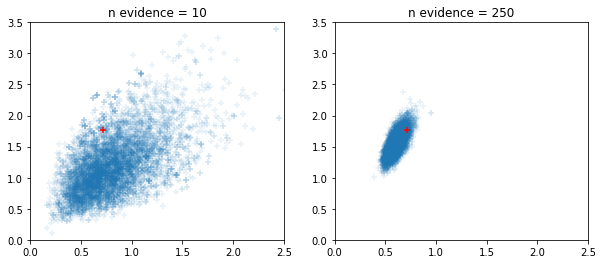

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i, n_evidence in enumerate((10, 250)):
  ax[i].set_title(f'n evidence = {n_evidence}')
  ax[i].set_xlim(0, 2.5); ax[i].set_ylim(0, 3.5)
  @tfd.JointDistributionCoroutine
  def model():
    Root = tfd.JointDistributionCoroutine.Root
    c0 = yield Root(tfd.Gamma(2, 2, name='c0'))
    c1 = yield Root(tfd.Gamma(2, 2, name='c1'))
    counts = yield tfd.Sample(tfd.BetaBinomial(23, c1, c0), n_evidence, name='counts')
  s = model.sample(seed=[20, 30])
  print(s)
  jd = model.experimental_pin(counts=s.counts)
  states, trace = tf.function(tfp.experimental.mcmc.windowed_adaptive_hmc)(
      100, jd, num_leapfrog_steps=5, seed=[100, 200])
  ax[i].scatter(states.c0.numpy().reshape(-1), states.c1.numpy().reshape(-1), 
                marker='+', alpha=.1)
  ax[i].scatter(s.c0, s.c1, marker='+', color='r')

## 数学、統計

- 数学/線形代数

    - 台形積分用に `tfp.math.trapz` が追加。
    - `tfp.math.log_bessel_kve` が追加。
    - `no_pivot_ldl` が `experimental.linalg` を追加。
    - `marginal_fn` が引数 `GaussianProcess` に追加。(`no_pivot_ldl` を参照)。
    - `tfp.math.atan_difference(x, y)` が追加。
    - `tfp.math.erfcx`、`tfp.math.logerfc` および `tfp.math.logerfcx` が追加。
    - ドーソン関数に `tfp.math.dawsn` が追加。
    - `tfp.math.igammaincinv`、 `tfp.math.igammacinv` が追加。
    - `tfp.math.sqrt1pm1` を追加します。
    - `LogitNormal.stddev_approx` と`LogitNormal.variance_approx` が追加。
    - Owen の T 関数に `tfp.math.owens_t` が追加。
    - ルート検索の境界を自動的に初期化する `bracket_root` メソッドが追加。
    - スカラー関数の根を見つけるための Chandrupatla のメソッドが追加。

- 統計

    - `tfp.stats.windowed_mean` はウィンドウ化された平均を効率的に計算します。
    - `tfp.stats.windowed_variance` はウィンドウ化された分散を効率的かつ正確に計算します。
    - `tfp.stats.cumulative_variance` は累積分散を効率的かつ正確に計算します。
    - `RunningCovariance` などでは、明示的な形状と dtype だけでなく、Tensor の例から初期化できるようになりました。
    - `RunningCentralMoments`、`RunningMean`、`RunningPotentialScaleReduction` 用のよりクリーンな API。


### Owen の T、Erfcx、Logerfc、Logerfcx、ダーソン関数

In [ ]:
# Owen's T gives the probability that X > h, 0 < Y < a * X. Let's check that
# with random sampling.
h = np.array([1., 2.]).astype(np.float32)
a = np.array([10., 11.5]).astype(np.float32)
probs = tfp.math.owens_t(h, a)

x = tfd.Normal(0., 1.).sample(int(1e5), seed=(6, 245)).numpy()
y = tfd.Normal(0., 1.).sample(int(1e5), seed=(7, 245)).numpy()

true_values = (
    (x[..., np.newaxis] > h) &
    (0. < y[..., np.newaxis]) &
    (y[..., np.newaxis] < a * x[..., np.newaxis]))

print('Calculated values: {}'.format(
    np.count_nonzero(true_values, axis=0) / 1e5))

print('Expected values: {}'.format(probs))

Calculated values: [0.07896 0.01134]
Expected values: [0.07932763 0.01137507]


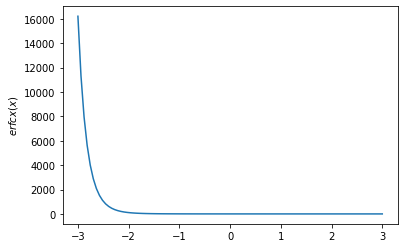

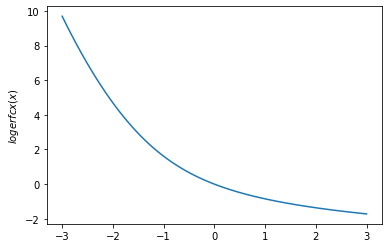

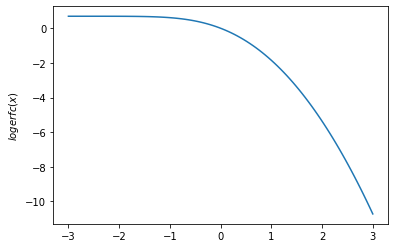

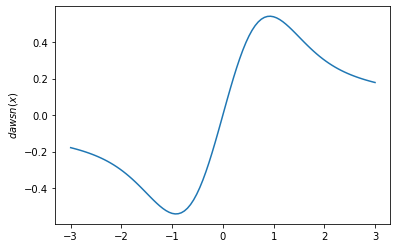

In [ ]:
x = np.linspace(-3., 3., 100)
plt.plot(x, tfp.math.erfcx(x))
plt.ylabel('$erfcx(x)$')
plt.show()

plt.plot(x, tfp.math.logerfcx(x))
plt.ylabel('$logerfcx(x)$')
plt.show()

plt.plot(x, tfp.math.logerfc(x))
plt.ylabel('$logerfc(x)$')
plt.show()

plt.plot(x, tfp.math.dawsn(x))
plt.ylabel('$dawsn(x)$')
plt.show()

### igammainv /  igammacinv

In [ ]:
# Igammainv and Igammacinv are inverses to Igamma and Igammac

x = np.linspace(1., 10., 10)
y = tf.math.igamma(0.3, x)
x_prime = tfp.math.igammainv(0.3, y)
print('x: {}'.format(x))
print('igammainv(igamma(a, x)):\n {}'.format(x_prime))

y = tf.math.igammac(0.3, x)
x_prime = tfp.math.igammacinv(0.3, y)

print('\n')
print('x: {}'.format(x))
print('igammacinv(igammac(a, x)):\n {}'.format(x_prime))

x: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
igammainv(igamma(a, x)):
 [1.        1.9999992 3.000003  4.0000024 5.0000257 5.999887  7.0002484
 7.999243  8.99872   9.994673 ]


x: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
igammacinv(igammac(a, x)):
 [1.       2.       3.       4.       5.       6.       7.       8.000001
 9.       9.999999]


### log-kve

Text(0.5, 1.0, 'Log(BesselKve(v, x)')

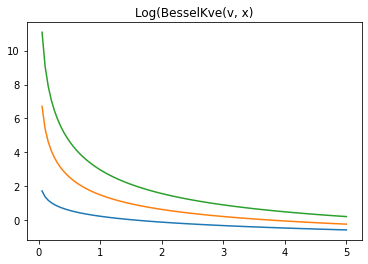

In [ ]:
x = np.linspace(0., 5., 100)
for v in [0.5, 2., 3]:
  plt.plot(x, tfp.math.log_bessel_kve(v, x).numpy())

plt.title('Log(BesselKve(v, x)')

## その他

- STS

    - 内部 `tf.function` ラッピングを使用して、STS の予測と分解を高速化します。
    - 最終ステップの結果のみが必要な場合に、`LinearGaussianSSM` でフィルタリングを高速化するオプションを追加します。
    - 同時分布による変分推論：[ラドンモデルを使用したノートブックの例](https://www.tensorflow.org/probability/examples/Variational_Inference_and_Joint_Distributions)。
    - ディストリビューションを前処理バイジェクタに変換するための実験的サポートを追加します。

- `tfp.random.sanitize_seed` を追加します。

- `tfp.random.spherical_uniform` を追加します。


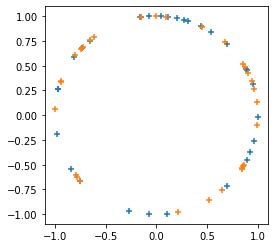

In [64]:
plt.figure(figsize=(4, 4))
seed = tfp.random.sanitize_seed(123)
seed1, seed2 = tfp.random.split_seed(seed)
samps = tfp.random.spherical_uniform([30], dimension=2, seed=seed1)
plt.scatter(*samps.numpy().T, marker='+')
samps = tfp.random.spherical_uniform([30], dimension=2, seed=seed2)
plt.scatter(*samps.numpy().T, marker='+');